In [153]:
#!/usr/bin/env python
# coding: utf-8

# In[ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
import numpy as np
import os
import sys
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
import itertools
from sklearn.preprocessing import StandardScaler #data scaling
from sklearn import decomposition #PCA
#import other python scripts for further anlaysis
import reshape
#import results
import warnings
warnings.filterwarnings("ignore")
# Initialization of directory information:
thisDir = os.path.expanduser('~/Desktop/MSC_Alexis/analysis/')
dataDir = thisDir + 'data/mvpa_data/'
#outDir = thisDir + 'output/results/'
outDir = thisDir + 'output/results/'
# Subjects and tasks
taskList=['glass','semantic', 'motor','mem']
#omitting MSC06 for classify All
subList=['MSC01','MSC02','MSC03','MSC04','MSC05','MSC07','MSC10']
#subList=['MSC01','MSC02','MSC03','MSC04','MSC05','MSC06','MSC07','MSC10']
#all possible combinations of subs and tasks
subsComb=(list(itertools.permutations(subList, 2)))
tasksComb=(list(itertools.permutations(taskList, 2)))
#DS combination
DSvars=list(itertools.product(list(subsComb),list(taskList)))
##SS combination
SSvars=list(itertools.product(list(subList),list(tasksComb)))
#BS combination
BSvars=list(itertools.product(list(subsComb),list(tasksComb)))
#CV combination
CVvars=list(itertools.product(list(subList),list(taskList)))

def classifyAll():
    """
    Classifying different subjects along available data rest split into 40 samples to match with task

    Parameters
    -------------

    Returns
    -------------
    df : DataFrame
        Dataframe consisting of average accuracy across all subjects

    """
    acc_scores_per_sub=[]
    acc_scores_cv=[]
    df=pd.DataFrame(subsComb, columns=['train_sub','test_sub'])
    for index, row in df.iterrows():
        diff_score, same_score=modelAll(train_sub=row['train_sub'], test_sub=row['test_sub'])
        acc_scores_per_sub.append(diff_score)
        acc_scores_cv.append(same_score)
    df['cv_acc']=acc_scores_cv
    df['acc']=acc_scores_per_sub
    return df
    #df.to_csv(outDir+'acc/ALL/shufflekFold_acc.csv',index=False)

def modelAll(train_sub, test_sub):
    """
    Preparing machine learning model with appropriate data

    Parameters
    -------------
    train_sub : str
            Subject name for training
    test_sub : str
            Subject name for testing

    Returns
    -------------
    total_score : float
            Average accuracy of all folds

    """
    clf=RidgeClassifier()
    df=pd.DataFrame()
    #train sub
    memFC=reshape.matFiles(dataDir+'mem/'+train_sub+'_parcel_corrmat.mat')
    semFC=reshape.matFiles(dataDir+'semantic/'+train_sub+'_parcel_corrmat.mat')
    glassFC=reshape.matFiles(dataDir+'glass/'+train_sub+'_parcel_corrmat.mat')
    motFC=reshape.matFiles(dataDir+'motor/'+train_sub+'_parcel_corrmat.mat')
    restFC=reshape.matFiles(dataDir+'rest/corrmats_timesplit/fourths/'+train_sub+'_parcel_corrmat.mat')
    #taskFC=np.concatenate((memFC,semFC,glassFC,motFC))
    #to have more control over sessions
    #taskFC=np.dstack((memFC,semFC,glassFC,motFC))#10x55278x4
    #taskFC=np.reshape(taskFC,(10,4,55278)) #lets just see if this changes anything
    restFC=np.reshape(restFC,(10,4,55278)) #reshape to match
    #test sub
    test_memFC=reshape.matFiles(dataDir+'mem/'+test_sub+'_parcel_corrmat.mat')
    test_semFC=reshape.matFiles(dataDir+'semantic/'+test_sub+'_parcel_corrmat.mat')
    test_glassFC=reshape.matFiles(dataDir+'glass/'+test_sub+'_parcel_corrmat.mat')
    test_motFC=reshape.matFiles(dataDir+'motor/'+test_sub+'_parcel_corrmat.mat')
    test_restFC=reshape.matFiles(dataDir+'rest/corrmats_timesplit/fourths/'+test_sub+'_parcel_corrmat.mat')
    test_taskFC=np.concatenate((test_memFC,test_semFC,test_glassFC,test_motFC))
    diff_score, same_score=K_folds(train_sub, clf, memFC,semFC,glassFC,motFC, restFC, test_taskFC,test_restFC)
    return diff_score, same_score
def K_folds(train_sub, clf, memFC,semFC,glassFC,motFC,restFC, test_taskFC, test_restFC):
    """
    Cross validation to train and test using nested loops

    Parameters
    -----------
    clf : obj
        Machine learning algorithm
    taskFC, restFC, test_taskFC, test_restFC : array_like
        Input arrays, training and testing set of task and rest FC
    Returns
    -----------
    total_score : float
        Average accuracy across folds
    acc_score : list
        List of accuracy for each outer fold
    """

    kf = KFold(n_splits=5,shuffle=True)
    #reshape rest to get specific days
    #having more control over sessions will require labeling within loop
    test_taskSize=test_taskFC.shape[0]
    test_restSize=test_restFC.shape[0]
    testT= np.ones(test_taskSize, dtype = int)
    testR= np.zeros(test_restSize, dtype = int)
    Xtest=np.concatenate((test_taskFC,test_restFC))
    ytest=np.concatenate((testT,testR))
    CVacc=[]
    df=pd.DataFrame()
    acc_score=[]
    #fold each training set
    for train_index, test_index in kf.split(memFC):   
        memtrain, memval=memFC[train_index], memFC[test_index]
        semtrain, semval=semFC[train_index], semFC[test_index]
        mottrain, motval=motFC[train_index], motFC[test_index]
        glatrain, glaval=glassFC[train_index], glassFC[test_index]
        Xtrain_task=np.concatenate((memtrain,semtrain,mottrain,glatrain))
        Xtrain_rest, Xval_rest=restFC[train_index,:,:], restFC[test_index,:,:]
        Xval_task=np.concatenate((memval,semval,motval,glaval))
        Xtrain_rest=np.reshape(Xtrain_rest,(32,55278))
        Xval_rest=np.reshape(Xval_rest,(8,55278))
        ytrain_task = np.ones(Xtrain_task.shape[0], dtype = int)
        ytrain_rest=np.zeros(Xtrain_rest.shape[0], dtype=int)
        yval_task = np.ones(Xval_task.shape[0], dtype = int)
        yval_rest=np.zeros(Xval_rest.shape[0], dtype=int)
        X_tr=np.concatenate((Xtrain_task, Xtrain_rest))
        X_val=np.concatenate((Xval_task, Xval_rest))
        y_tr = np.concatenate((ytrain_task,ytrain_rest))
        y_val=np.concatenate((yval_task, yval_rest))
        clf.fit(X_tr,y_tr)
        #get accuracy
        CV_score=clf.score(X_val, y_val)
        CVacc.append(CV_score)
        score=clf.score(Xtest,ytest)
        acc_score.append(score)
    df['cv']=CVacc
    #other sub
    df['outer_fold']=acc_score
    same_sub_score=df['cv'].mean()
    diff_sub_score=df['outer_fold'].mean()
    return diff_sub_score, same_sub_score

In [154]:
df=classifyAll()

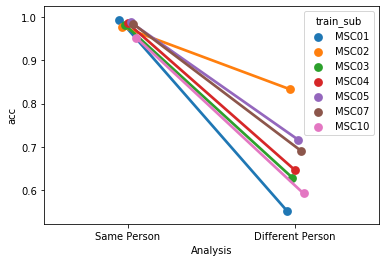

In [155]:
import seaborn as sns
df_re=df.groupby(['train_sub']).mean()
df_re.rename(columns={'cv_acc':'Same Person','acc':'Different Person'},inplace=True)
df_re.reset_index(inplace=True)
fin=pd.melt(df_re, id_vars=['train_sub'], value_vars=['Same Person','Different Person'],var_name='Analysis',value_name='acc')
ax=sns.pointplot(x="Analysis",y="acc", hue="train_sub",ci=None, data=fin, dodge=.1,order=['Same Person','Different Person'])


In [26]:
train_sub='MSC02'
test_sub='MSC05'
clf=RidgeClassifier()
df=pd.DataFrame()
#train sub
memFC=reshape.matFiles(dataDir+'mem/'+train_sub+'_parcel_corrmat.mat')
semFC=reshape.matFiles(dataDir+'semantic/'+train_sub+'_parcel_corrmat.mat')
glassFC=reshape.matFiles(dataDir+'glass/'+train_sub+'_parcel_corrmat.mat')
motFC=reshape.matFiles(dataDir+'motor/'+train_sub+'_parcel_corrmat.mat')
restFC=reshape.matFiles(dataDir+'rest/'+train_sub+'_parcel_corrmat.mat')
taskFC=np.concatenate((memFC,semFC,glassFC,motFC))
#to have more control over sessions
#taskFC=np.dstack((memFC,semFC,glassFC,motFC))#10x55278x4
testFC=np.reshape(restFC,(10,55278,4)) #reshape to match
#test sub
test_memFC=reshape.matFiles(dataDir+'mem/'+test_sub+'_parcel_corrmat.mat')
test_semFC=reshape.matFiles(dataDir+'semantic/'+test_sub+'_parcel_corrmat.mat')
test_glassFC=reshape.matFiles(dataDir+'glass/'+test_sub+'_parcel_corrmat.mat')
test_motFC=reshape.matFiles(dataDir+'motor/'+test_sub+'_parcel_corrmat.mat')
test_restFC=reshape.matFiles(dataDir+'rest/corrmats_timesplit/fourths/'+test_sub+'_parcel_corrmat.mat')
test_taskFC=np.concatenate((test_memFC,test_semFC,test_glassFC,test_motFC))

In [52]:
restFC.shape

(40, 55278)

In [72]:
from sklearn import datasets 
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split 
  
# loading the iris dataset 
iris = datasets.load_iris() 
  
# X -> features, y -> label 
X = iris.data 
y = iris.target 

In [73]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [17]:
ytrain_task = np.ones(taskFC.shape[0], dtype = int)
ytrain_rest=np.zeros(restFC.shape[0], dtype=int)


ytest_task = np.ones(test_taskFC.shape[0], dtype = int)
ytest_rest=np.zeros(test_restFC.shape[0], dtype=int)

X=np.concatenate((taskFC,restFC))
y=np.concatenate((ytrain_task,ytrain_rest))

X_test=np.concatenate((test_taskFC,test_restFC))
y_test=np.concatenate((ytest_task,ytest_rest))

In [18]:
clf.fit(X,y)
clf.score(X_test,y_test)

0.95

In [17]:
Xtrain_task, Xval_task=taskFC[0:8,:,:], taskFC[8:10,:,:]
Xtrain_rest, Xval_rest=restFC[0:8,:,:], restFC[8:10:,:]
#reshape for this to work
Xtrain_task=np.reshape(Xtrain_task,(32,55278))
Xval_task=np.reshape(Xval_task,(8,55278))
Xtrain_rest=np.reshape(Xtrain_rest,(32,55278))
Xval_rest=np.reshape(Xval_rest,(8,55278))

ytrain_task = np.ones(Xtrain_task.shape[0], dtype = int)
ytrain_rest=np.zeros(Xtrain_rest.shape[0], dtype=int)

yval_task = np.ones(Xval_task.shape[0], dtype = int)
yval_rest=np.zeros(Xval_rest.shape[0], dtype=int)
X_tr=np.concatenate((Xtrain_task, Xtrain_rest))
X_val=np.concatenate((Xval_task, Xval_rest))
y_tr = np.concatenate((ytrain_task,ytrain_rest))
y_val=np.concatenate((yval_task, yval_rest))
clf.fit(X_tr,y_tr)
#cross validation
#get accuracy
CV_score=clf.score(X_val, y_val)

In [19]:
clf.score(X_val, y_val)

1.0

In [20]:
clf.predict(X_val)

array([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0])

In [28]:
clf.predict(X_te)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [20]:
kf = KFold(n_splits=5)
for train_index, test_index in kf.split(memFC):
    print("TRAIN:", train_index, "TEST:", test_index)

TRAIN: [2 3 4 5 6 7 8 9] TEST: [0 1]
TRAIN: [0 1 4 5 6 7 8 9] TEST: [2 3]
TRAIN: [0 1 2 3 6 7 8 9] TEST: [4 5]
TRAIN: [0 1 2 3 4 5 8 9] TEST: [6 7]
TRAIN: [0 1 2 3 4 5 6 7] TEST: [8 9]


In [1]:
import masterClass
df=masterClass.classifyAll()

In [21]:
test_index


array([8, 9])

In [2]:
df

,train_sub,test_sub,cv_acc,cv_sen,cv_spec,acc,ds_sen,ds_spec
0,MSC01,MSC02,1.0000,1.000,1.000,0.5175,1.000,0.035
1,MSC01,MSC03,1.0000,1.000,1.000,0.5150,0.985,0.045
2,MSC01,MSC04,1.0000,1.000,1.000,0.6150,1.000,0.230
3,MSC01,MSC05,0.9875,1.000,0.975,0.5900,1.000,0.180
4,MSC01,MSC07,1.0000,1.000,1.000,0.5100,1.000,0.020
5,MSC01,MSC10,1.0000,1.000,1.000,0.5175,1.000,0.035
6,MSC02,MSC01,1.0000,1.000,1.000,0.9225,0.885,0.960
7,MSC02,MSC03,1.0000,1.000,1.000,0.7700,0.970,0.570
8,MSC02,MSC04,1.0000,1.000,1.000,0.9125,0.985,0.840
9,MSC02,MSC05,1.0000,1.000,1.000,0.9275,0.970,0.885


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
df_re=df.groupby(['train_sub']).mean()
df_re.rename(columns={'cv_acc':'Same Person','acc':'Different Person'},inplace=True)
df_re.reset_index(inplace=True)
res=pd.melt(df_re, id_vars=['train_sub'], value_vars=['Same Person','Different Person'],var_name='Analysis',value_name='acc')


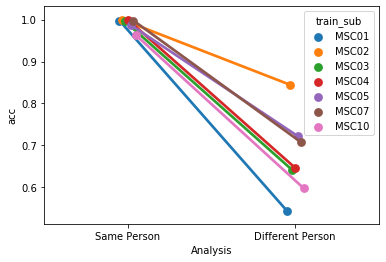

In [6]:
ax=sns.pointplot(x="Analysis",y="acc", hue="train_sub",ci=None, data=res, dodge=.1,order=['Same Person','Different Person'])


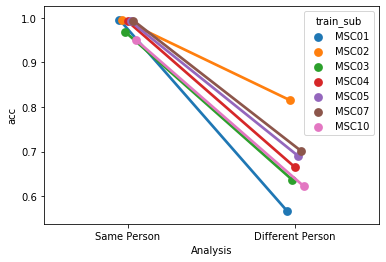

In [3]:
ax=sns.pointplot(x="Analysis",y="acc", hue="train_sub",ci=None, data=res, dodge=.1,order=['Same Person','Different Person'])


In [ ]:
import block_featSelection

#block_featSelection.Net2Net()
block_featSelection.subNetAll() #run this when done

In [1]:
#import reshape
#df=reshape.network_to_network('/Users/Alexis/Desktop/MSC_Alexis/analysis/data/mvpa_data/mem/MSC03_parcel_corrmat.mat','default','visual')
#df=reshape.matFiles('/Users/Alexis/Desktop/MSC_Alexis/analysis/data/mvpa_data/mem/MSC03_parcel_corrmat.mat')
#X_tr.shape